In [1]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

In [159]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

# Sepsis (Angus)

The query to get the Angus definition of sepsis is available in mimic_code. It collates information for each `hadm_id`, from `DIAGNOSES_ICD` for infection, organ dysfunction and explicit sespsis and `PROCEDURES_ICD` for mechanical ventilation. The Angus column is set to 1 if `explicit_sepsis` is 1, or if `infection` and `organ_dysfunction` are 1, or if `infection` and `mechanical ventilation` are 1. 

Note that both `DIAGNOSES_ICD` and `PROCEDURES_ICD` are only associated with `hadm_id` and not `icustay_id`. However, this should not be a problem if we filter the echos for single icu stays. 

In [209]:
query = \
"""
SELECT * FROM angus_sepsis;
"""
angus = pd.read_sql_query(query, con)
angus.head()

,subject_id,hadm_id,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus
0,22,165315,0,0,0,1,0
1,23,152223,0,0,0,0,0
2,23,124321,0,0,0,0,0
3,24,161859,0,0,0,0,0
4,25,129635,0,0,0,0,0


# Sepsis (proposed)

The proposed definition of sepsis from our last meeting was: 

+ On antibiotics
+ On pressors within 48 hours
+ Not in cardiogenic shock/pulmonary embolism/haem shock

# ICU stays with associated echos

Extract information about icustays where the icustay_id/hadm_id is associated with an echo. Filter hadm_ids which have multiple icustay_ids. 

In [160]:
query = \
"""
SELECT * FROM echo_icustay;
"""
icu = pd.read_sql_query(query, con)
icu.head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,gender,subject_id,admittime,dischtime,ethnicity,age,time_to_echo,max_icustay_seq,time_filter
0,76338,100003,2150-04-18 12:36:00,209281,2.0,1,Y,M,54610,2150-04-17 15:34:00,2150-04-21 17:30:00,WHITE,59.9110,0 days 21:02:00,1,True
1,68597,100006,2108-04-10 10:01:00,291788,5.0,1,Y,F,9895,2108-04-06 15:49:00,2108-04-18 17:18:00,BLACK/AFRICAN AMERICAN,48.9155,3 days 18:12:00,1,False
2,77734,100009,2162-05-17 14:55:00,253656,2.0,1,Y,M,533,2162-05-16 15:56:00,2162-05-21 13:37:00,WHITE,60.7953,0 days 22:59:00,1,True
3,76983,100012,2177-03-15 08:24:00,239289,4.0,1,Y,M,60039,2177-03-12 11:48:00,2177-03-22 14:30:00,WHITE,67.7113,2 days 20:36:00,1,False
4,76985,100012,2177-03-12 14:54:00,239289,4.0,1,Y,M,60039,2177-03-12 11:48:00,2177-03-22 14:30:00,WHITE,67.7113,0 days 03:06:00,1,True


Comment out or edit `WHERE max_icustay_seq = 1` to be able to run the next two cells, which looks at the number of icustay_ids within a hadm_id, and an example where there are multiple icustay_ids within a hadm_id. 

In [68]:
icu.groupby('hadm_id')['icustay_id'].apply(lambda c: len(c.unique())).sort_values(ascending = False).value_counts()

1    21290
2     1861
3      257
4       47
5        7
6        3
7        2
Name: icustay_id, dtype: int64

In [69]:
icu.loc[icu['hadm_id'] == 186706].head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,gender,admittime,dischtime,ethnicity,admittime,max_icustay_seq
33799,72512,186706,2188-09-08 15:50:00,294576,8.0,1,Y,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33800,72879,186706,2188-09-19 16:32:00,294576,8.0,1,Y,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33801,72880,186706,2188-08-26 11:33:00,294576,8.0,1,Y,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33802,72879,186706,2188-09-19 16:32:00,240759,7.0,2,N,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7
33803,72512,186706,2188-09-08 15:50:00,240759,7.0,2,N,M,2188-07-16 19:24:00,2188-09-25 14:30:00,WHITE,2188-07-16 19:24:00,7


There are 21290 such echos. 

## Distribution of number of echos by time w.r.t admittime

Count the number of echos between -8 to 48 hours

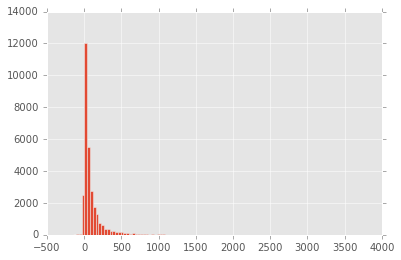

In [138]:
(icu['time_to_echo'] / np.timedelta64(1, 'h')).hist(bins = 100)

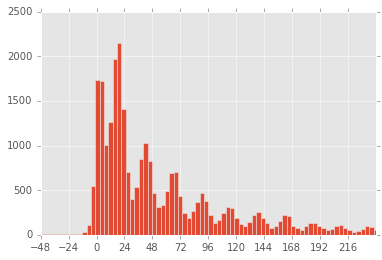

In [139]:
ax = (icu['time_to_echo'] / np.timedelta64(1, 'h')).hist(bins = 1000)
plt.xlim([-48, 240])
ticklabels = np.arange(-48, 240)[::24]
_ = plt.xticks(ticklabels)

In [141]:
((icu['time_to_echo'] > np.timedelta64(-8, 'h')) & 
 (icu['time_to_echo'] < np.timedelta64(48, 'h'))).value_counts()

True     16330
False    13385
Name: time_to_echo, dtype: int64

In [147]:
icu['time_filter'].value_counts()

True     16330
False    13385
Name: time_filter, dtype: int64

There are 16330 ICU echos that were taken between -8 to 48 h. The distributions on gender and age are computed on these: 

## Distribution on gender

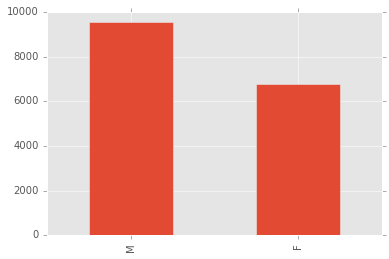

In [148]:
icu.loc[icu['time_filter'], 'gender'].value_counts().plot(kind = 'bar')

## Distribution on age

Computed as admittime - dob

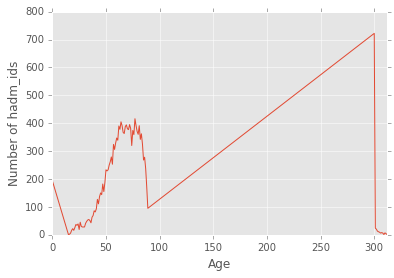

In [150]:
round(icu.loc[icu['time_filter'], 'age']).value_counts().sort_index().plot()
plt.xlabel('Age')
plt.ylabel('Number of hadm_ids')

## Number of echos associated with sepsis (Angus)

In [212]:
res = pd.merge(angus, icu, on = 'hadm_id', suffixes = ('_angus', '_icu'))
res.head()

,subject_id_angus,hadm_id,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus,row_id,charttime,icustay_id,...,first_icu_stay,gender,subject_id_icu,admittime,dischtime,ethnicity,age,time_to_echo,max_icustay_seq,time_filter
0,24,161859,0,0,0,0,0,78797,2139-06-08 10:31:00,262236,...,Y,M,24,2139-06-06 16:14:00,2139-06-09 12:48:00,WHITE,39.0152,1 days 18:17:00,1,True
1,25,129635,0,0,0,0,0,78499,2160-11-02 11:16:00,203487,...,Y,M,25,2160-11-02 02:06:00,2160-11-05 14:55:00,WHITE,58.9500,0 days 09:10:00,1,True
2,26,197661,0,0,0,0,0,65191,2126-05-10 11:47:00,244882,...,Y,M,26,2126-05-06 15:16:00,2126-05-13 15:00:00,UNKNOWN/NOT SPECIFIED,72.0043,3 days 20:31:00,1,False
3,30,104557,0,0,0,0,0,70141,2172-10-15 14:05:00,225176,...,Y,M,30,2172-10-14 14:17:00,2172-10-19 14:37:00,UNKNOWN/NOT SPECIFIED,300.0011,0 days 23:48:00,1,True
4,33,176176,1,0,0,0,0,61623,2116-12-24 09:22:00,296681,...,Y,M,33,2116-12-23 22:30:00,2116-12-27 12:05:00,UNKNOWN/NOT SPECIFIED,82.3919,0 days 10:52:00,1,True


In [213]:
res['explicit_sepsis'].value_counts()

0    26476
1     3239
Name: explicit_sepsis, dtype: int64

In [214]:
res['angus'].value_counts()

0    18555
1    11160
Name: angus, dtype: int64

# Outpatient echos

In [157]:
query = \
"""
SELECT * FROM echodata
WHERE status = 'Outpatient';
"""
echo_op = pd.read_sql_query(query, con)
echo_op.head()

,row_id,subject_id,hadm_id,chartdate,charttime,indication,height,weight,bsa,bp,bpsys,bpdias,hr,status,test,doppler,contrast,technicalquality
0,77922,7949,NaN,2124-08-31,2124-08-31 14:00:00,Preoperative assessment.,65.0,149.0,1.75,125/82,125.0,82.0,72.0,Outpatient,TTE (Complete),Full Doppler and color Doppler,None,Adequate
1,78193,25929,NaN,2201-06-04,2201-06-04 13:42:00,Aortic valve disease. Left ventricular function.,NaN,115.0,NaN,165/60,165.0,60.0,70.0,Outpatient,TTE (Complete),Full Doppler and color Doppler,None,Adequate
2,78194,25929,NaN,2200-05-14,2200-05-14 11:00:00,Follow up aortic regurgitation,NaN,NaN,NaN,142/78,142.0,78.0,NaN,Outpatient,TTE (Complete),Full doppler and color doppler,None,Adequate
3,78195,587,150352.0,2100-10-28,2100-10-28 13:45:00,Chemotherapy.,69.0,202.0,2.08,120/80,120.0,80.0,95.0,Outpatient,TTE (Complete),Full doppler and color doppler,None,Adequate
4,77945,11201,175064.0,2122-01-16,2122-01-16 11:45:00,Shortness of breath. Congestive heart failure...,67.0,185.0,1.96,120/68,120.0,68.0,88.0,Outpatient,TTE (Complete),Full doppler and color doppler,None,Suboptimal


Number of pairs of echos:

In [184]:
echo_op['subject_id'].value_counts().value_counts()

1     3147
2      745
3      284
4      117
5       48
6       28
7       18
8        9
10       5
9        5
11       2
12       2
15       1
Name: subject_id, dtype: int64

For each ICU echo, calculate the chart time on the outpatient echo minus the chart time on the ICU echo: 

True     6854
False    5157
dtype: int64

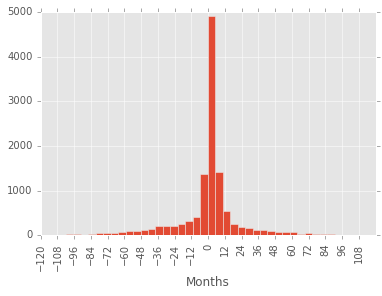

In [189]:
res = pd.merge(icu, echo_op, on = 'subject_id', suffixes = ('_icu', '_op'))
((res['charttime_op'] - res['charttime_icu'])/ np.timedelta64(1, 'M')).hist(bins = 50)
plt.xlim([-12*10, 12*10])
ticklabels = np.arange(-120, 120)[::12]
_ = plt.xticks(ticklabels, rotation = 90)
plt.xlabel('Months')

(res['charttime_op'] > res['charttime_icu']).value_counts()

Looking at the pairs of echos where the outpatient echo occurred before the ICU echo, these are the indications for the outpatient echo. It doesn't look like these are in any way 'baseline' echos? 

In [204]:
res.loc[res['charttime_icu'] > res['charttime_op']][[
        'charttime_op', 'charttime_icu', 'indication']].sample(n = 10)

,charttime_op,charttime_icu,indication
919,2146-10-04 11:00:00,2148-09-25 14:51:00,CABG. Congestive heart failure. Left ventricul...
5366,2184-03-17 14:00:00,2185-03-23 13:46:00,R/O CLOT
9547,2198-01-18 09:43:00,2198-01-19 10:07:00,?Left atrial mass.
2752,2118-12-20 10:00:00,2119-01-13 15:13:00,followup PCI [**6-14**]
2694,2114-04-24 08:02:00,2115-07-09 09:22:00,Left ventricular function. Right ventricular f...
312,2167-09-25 11:00:00,2172-07-22 15:35:00,Congestive heart failure.
9508,2127-06-18 15:16:00,2127-06-20 11:36:00,Tamponade
6045,2114-05-01 15:00:00,2114-05-09 13:24:00,Atrial flutter. Aortic valve disease. Status...
4435,2138-08-11 11:00:00,2138-12-05 09:36:00,Myocardial infarction.
1577,2184-08-31 14:00:00,2188-05-25 09:27:00,F/U Pericardial Effustion
